# Job Application Test - Lâm Lê Thanh Thế
# Airflight Delay Prediction

## About The Project

- This project serves as a technical test for the "Data Science Specialist" position application of FE Credit, Vietnam.

- Assignee as well as owner:

| | |
| :- | :- |
| **Full Name** | Lâm Lê Thanh Thế |
| **Phone** | 0979 093 710 |
| **Email** | lamlethanhthe@gmail.com |

- May-June, 2021

## Problem Statement

- This project aims at predicting airflight delays using [the data of airline information from Data Expo 2009](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009), following the requirements stated in ***project_requirements.docx***.

- As defined in the requirements, a flight will be counted as late if it is **more than** 30 minutes late; hence it will be considered as just on time when exactly 30 minutes behind the schedule.

### Two types of airflight delays

- Talking about airflight delays, one could mean:

    - **Departure Delays**: when a flight takes off later than the scheduled time from *computer/central reservation systems (CRS)*.

    - **Arrival Delays**: when a flight arrives later than the scheduled time from CRS.

- **For simplicity and to the extent of demonstration, this project will only consider *Departure delays* as its sole subject to predict.**

    - *Reason*: Departure delays are usually what annoy customers more than arrival delays, and arrival delays of one flight can be regared in the contribution to other flights' departure delays.

### Partial data considered only

- The original dataset from Data Expo 2019 is extremely large, containing airline information of the USA from 1987 to 2008 (20 years), with nearly 120 million records, 1.6GB compressed size and over 12GB unpacked size.

- Therefore, **due to the resource limitations of my local machine, I will only conduct this project over the data of 2008**, with a good aware that fewer data can lead to lower models' performances. However, I believe this will not alter the original purpose of this project as a technical test.

## Environment Setup

In [2]:
'''
Preparing Google Colab.
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Job Application Tmp/FECredit-LamLeThanhThe/'

/content/drive/MyDrive/Job Application Tmp/FECredit-LamLeThanhThe


In [ ]:
# !pip install keras-tuner
# !conda install -c conda-forge keras-tuner

In [1]:
'''
Preparing libraries.
'''

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn import svm, tree
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch

## Data Preparation and Description

- The data can be found in ***2008.csv***.

In [2]:
'''
Loading data.
'''

DAT_PATH = './2008.csv'

df = pd.read_csv(DAT_PATH)
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


In [ ]:
print('Number of records:', f'{len(df.index):,}')
print('Number of features:', len(df.columns))
print('Features:')
print(df.columns)

Number of records: 7,009,728
Number of features: 29
Features:
Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'],
      dtype='object')


### Features explained

- **Year**
    - The year the flight took place.
    - For this selected data, it is 2008 constantly.

- **Month**
    - The month the flight took place, in number format: 1, 2, 3, 4, ..., 12.

- **DayofMonth**
    - The day of month the flight took place, in number format, eg. 1, 2, ..., 31 *(for a month of 31 days)*.

- **DayOfWeek**
    - The day of week the flight took place, in number format: 1, 2, ..., 7.
    - 1 means Sunday.

- **DepTime**
    - The actual departure time of the flight, in 24-hour format.
    - Hour and minute are concatenated into a single number, eg. 1923 means 19:23, or 7:23 PM.
    - Marked as 'NA' ('NaN') if the flight was canceled.

- **CRSDepTime**
    - The scheduled departure time of the flight from computer/central reservation systems (CRS).
    - Same format and rules as *DepTime*.

- **ArrTime**
    - The actual arrival time of the flight.
    - Same format and rules as *DepTime*.
    - Marked as 'NA' ('NaN') if the flight was canceled or diverted.

- **CRSArrTime**
    - The scheduled arrival time of the flight from CRS.
    - Same format and rules as *DepTime*.

- **UniqueCarrier**
    - A string code for the airline operating the flight.
    - Seems to follow [IATA airline code](https://www.iata.org/en/publications/directories/code-search/) format.

- **FlightNum**
    - A positive integer code for the flight.

- **TailNum**
    - A string code for the flight's airplane.

- **ActualElapsedTime**
    - How long, in minutes, the flight actually took place.
    - Marked as 'NA' ('NaN') if the flight was canceled or diverted.

- **CRSElapsedTime**
    - How long, in minutes, the flight took place estimated by CRS.

- **AirTime**
    - How long, in minutes, the airplane is airborne.
    - Marked as 'NA' ('NaN') if the flight was canceled or diverted.

- **ArrDelay**
    - How much, in minutes, the arrival delay is.
    - Negative number means the flight arrived earlier than CRS scheduled.
    - Marked as 'NA' ('NaN') if the flight was canceled or diverted.

- **DepDelay**
    - Same as *ArrDelay* but for departure delay.
    - Marked as 'NA' ('NaN') if the flight was canceled.

- **Origin**
    - The location where the flight took off.

- **Dest**
    - The location where the flight headed.

- **Distance**
    - Distance between the origin and destination in kilometers.

- **TaxiIn**
    - How long, in minutes, the airplane moved on the ground into the hangar.
    - This is for docking the airplane at the destination's airport after the flight arrives.
    - Marked as 'NA' ('NaN') if the flight was canceled or diverted.

- **TaxiOut**
    - Same as *TaxiIn* but the airplane exited the hangar to take off.
    - Marked as 'NA' ('NaN') if the flight was canceled.

- **Cancelled**
    - Whether the flight was cancelled, coded as 0 - No and 1 - Yes.

- **CancellationCode**
    - A string code for the cancellation type, eg. A, B, C, D, ...
    - Left blank if the flight was not cancelled.

- **Diverted**
    - Whether the flight changed direction to a different destination or not, coded as 0 - No and 1 - Yes.

- **CarrierDelay**
    - How long, in minutes, of delays due to other carrier (airline) services.
    - Marked as 'NA' ('NaN') if no delay or the flight was canceled or diverted.

- **WeatherDelay**
    - How long, in minutes, the flight was delayed due to bad weather.
    - Marked as 'NA' ('NaN') if no delay or the flight was canceled or diverted.    

- **NASDelay**
    - How long, in minutes, of delays due to The National Airspace System (NAS) - an airflights and airports controlling system of the USA.
    - Marked as 'NA' ('NaN') if no delay or the flight was canceled or diverted.

- **SecurityDelay**
    - How long, in minutes, of delays due to security problems.
    - Marked as 'NA' ('NaN') if no delay or the flight was canceled or diverted.

- **LateAircraftDelay**
    - How long, in minutes, of delays due to slow airplane preparation.
    - Marked as 'NA' ('NaN') if no delay or the flight was canceled or diverted.

### Data preprocessing

- We do not need cancelled flights as they do not have departure delay times needed to learn in this project.

- When a flight is cancelled or diverted, arrival and flying information such as ArrTime, ArrDelay, ActualElapsedTime, ... is not available. Actually, as agreed that we only learn departure delays, those features are believed to have weak relations with our subject; hence, we can obmit them.

- TaxiOut, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, and LateAircraftDelay are sometimes marked as 0 as well as 'NaN' inconsistently in this dataset. We can replace all 'NaN' values with 0 without changing the features' meanings.

In [3]:
# Removing cancelled flights which have DepDelay = 'NaN'.
df.dropna(subset=['DepDelay'], inplace=True)

# Removing unrelated columns compared with DepDelay, eg. arrival, flying, and cancellation info.
df.drop(columns=['ArrTime', 'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'Cancelled', 'CancellationCode', 'TaxiIn'], inplace=True)

# Replacing other 'NaN' delay times as 0.
df.fillna({'TaxiOut': 0, 'CarrierDelay': 0, 'WeatherDelay': 0, 'NASDelay': 0, 'SecurityDelay': 0, 'LateAircraftDelay': 0}, inplace=True)

df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,UniqueCarrier,FlightNum,TailNum,DepDelay,Origin,Dest,Distance,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,WN,335,N712SW,8.0,IAD,TPA,810,8.0,0,0.0,0.0,0.0,0.0,0.0
1,2008,1,3,4,754.0,735,WN,3231,N772SW,19.0,IAD,TPA,810,10.0,0,0.0,0.0,0.0,0.0,0.0
2,2008,1,3,4,628.0,620,WN,448,N428WN,8.0,IND,BWI,515,17.0,0,0.0,0.0,0.0,0.0,0.0
3,2008,1,3,4,926.0,930,WN,1746,N612SW,-4.0,IND,BWI,515,7.0,0,0.0,0.0,0.0,0.0,0.0
4,2008,1,3,4,1829.0,1755,WN,3920,N464WN,34.0,IND,BWI,515,10.0,0,2.0,0.0,0.0,0.0,32.0


In [ ]:
print('After preprocessing,')
print('Number of records:', f'{len(df.index):,}')
print('Number of features:', f'{len(df.columns)}')

After preprocessing,
Number of records: 6,873,482
Number of features: 20


### Statistics of Departure delays

In [ ]:
depDelays = df['DepDelay']

print('Min:', np.min(depDelays))
print('Max:', np.max(depDelays))
print('Mean:', np.mean(depDelays))
print('Median:', np.median(depDelays))

std = np.std(depDelays)
print('Standard deviation:', std) # statistics.stdev() is slow for large numpy array
print('Variance:', std ** 2)

q1 = np.percentile(depDelays, 25, interpolation='midpoint')
q3 = np.percentile(depDelays, 75, interpolation='midpoint')
print('Q1:', q1)
print('Q3:', q3)
print('IQR:', q3 - q1)

Min: -534.0
Max: 2467.0
Mean: 9.972570088930182
Median: -1.0
Standard deviation: 35.31126820889378
Variance: 1246.8856625204326
Q1: -4.0
Q3: 8.0
IQR: 12.0


## Data Filtering and Visualization

- For demonstration, only some features will be used in each plot.

- Sometimes, data filtering is carried when preparing data for a plot.

### Scatter plot

- Plotting DepDelay against DepTime.

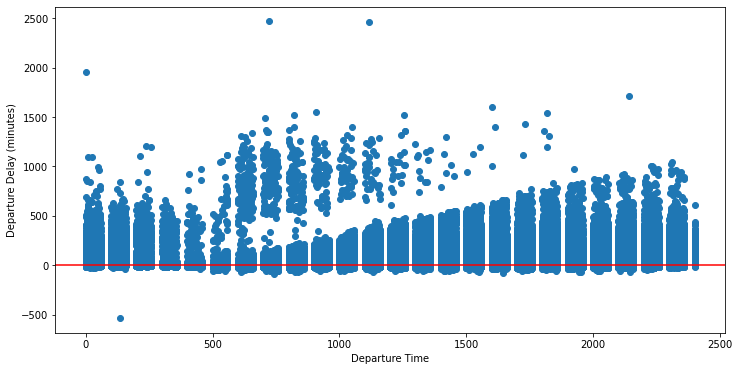

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(df['DepTime'], depDelays)
plt.xlabel('Departure Time')
plt.ylabel('Departure Delay (minutes)')
plt.axhline(y=0, color='r')
plt.show()

- **Observations:**

    - Departure delays commonly fall in the range of a bit smaller than 0 up to 1500 minutes . Only a few, 4-5, outliers are not in this range.
    
    - Lates are much longer around 6 AM to 2 PM, with many in 1000 to 1500 minutes. Outside these hours, lates usually take from 0 to 600 minutes.

### Bar graph

- Plotting counts of delays over 30 minutes among days of week, across months.

In [ ]:
DELAY_THRESHOLD = 30

barDat = df[['Month', 'DayOfWeek', 'DepDelay']]
barDat = barDat[barDat['DepDelay'] > DELAY_THRESHOLD]
barDat = barDat.groupby(['Month', 'DayOfWeek']).count().reset_index()

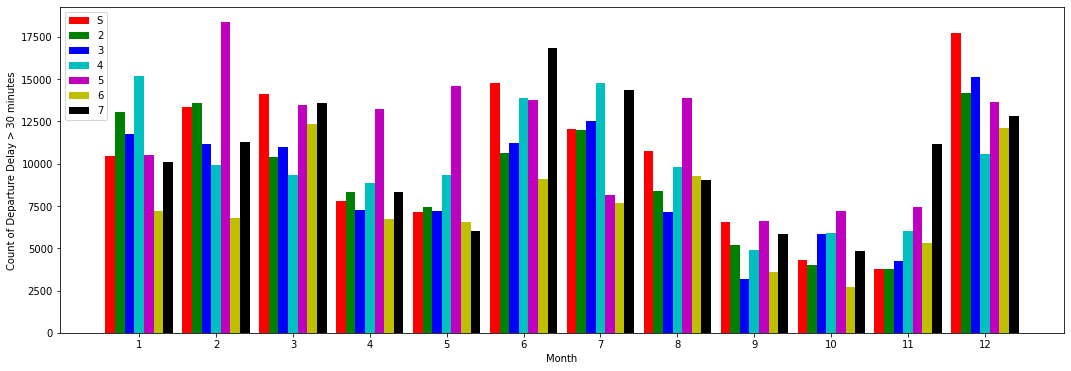

In [ ]:
BAR_WIDTH = 0.25

plt.figure(figsize=(18, 6))

X = [barDat[barDat['DayOfWeek'] == i]['DepDelay'].values for i in range(1, 8)]

pos = [[2 * i for i in range(len(X[0]))]]
for i in range(1, 7):
    pos.append([x + BAR_WIDTH for x in pos[i - 1]])

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
labels = ['S', '2', '3', '4', '5', '6', '7']

for i in range(7):
    plt.bar(pos[i], X[i], color=colors[i], width=BAR_WIDTH, label=labels[i])

plt.xlabel('Month')
plt.ylabel('Count of Departure Delay > 30 minutes')
plt.xticks([r + BAR_WIDTH * 3 for r in pos[0]], [str(j) for j in range(1, 13)])
plt.legend()

plt.show()

- **Observations:**
    
    - Sunday has really high delay counts in December, as people are having Christmas and New Year.
    
    - In other months, Thursday and Saturday usually have high delay counts in a month.

    - Over all days of week, the number of delays are high in the begining (first 3 months), the middle (June to August), and the end (December) of year 2008. It tends to be low in April - May and even lower in September to November.

### Histogram

- Plotting DepDelay, after removing some outliers outside [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].

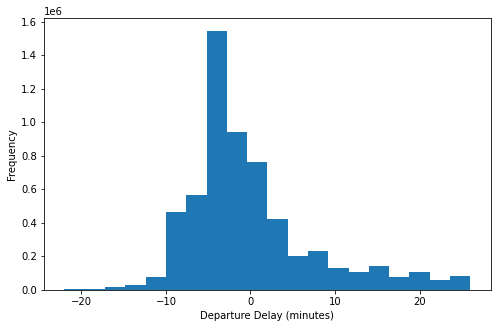

In [ ]:
iqr = q3 - q1
lowerLim = q1 - 1.5 * iqr
upperLim = q3 + 1.5 * iqr

histDat = [x for x in depDelays if x >= lowerLim and x <= upperLim]

plt.figure(figsize=(8, 5))
plt.hist(histDat, bins=20)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

- **Observations:**

    - Surprisingly, most departure delays occur around -10 to 4 minutes, which means flights tend to take off sooner than CRS scheduled. There are upto 1,600,000 flights departing approximately 5 minutes early.

    - The number of flights taking off more than 4 minutes late tend to be small, appearing lower than 200,000 cases.

### Box plot

- Plotting DepDelay.

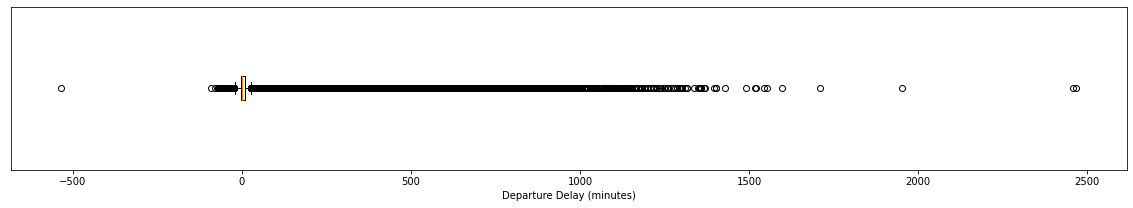

In [ ]:
boxDat = depDelays

plt.figure(figsize=(20, 3))
plt.boxplot(boxDat, vert=False)
plt.yticks([], [])
plt.xlabel('Departure Delay (minutes)')
plt.show()

- **Observations:**

    - The box plot agrees with the histogram above, indicating that most departure delays are around -20 to 20 minutes; hence we see a small rectangle around 0.

    - Other delay times are outliers. Even though their frequencies are low, their scales are really high. A flight took off more than 500 minutes sooner than CRS planned, while some other over 1500 upto 2500 minutes later.

### Sub plots and Pie chart

- Plotting DepDelay counts across months, with the group of positive (late) flights and negative (early) ones separately in two line charts but in the same subplot.

- In the second subplot, a stacked bar chart for the delay counts of late and early group across months will be plotted.

- Finally, in the last subplot, we will plot the total number of late flights against early ones.

- Flights having 0 departure delay are considered early *(just on time)*.

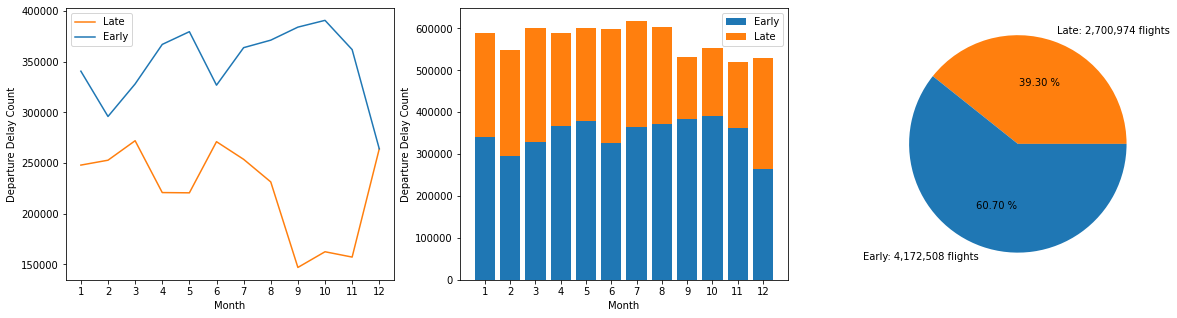

In [ ]:
tmp = df[['Month', 'DepDelay']]

lateDat = tmp[tmp['DepDelay'] > 0]
earlyDat = tmp[tmp['DepDelay'] <= 0]

subDatLate = lateDat.groupby('Month').count().reset_index()
subDatEarly = earlyDat.groupby('Month').count().reset_index()

plt.figure(figsize=(20, 5))
COLOR_LATE = 'tab:orange'
COLOR_EARLY = 'tab:blue'

plt.subplot(1, 3, 1)
plt.plot(subDatLate['Month'], subDatLate['DepDelay'], color=COLOR_LATE, label='Late')
plt.plot(subDatEarly['Month'], subDatEarly['DepDelay'], color=COLOR_EARLY, label='Early')
plt.legend()
plt.xlabel('Month')
plt.ylabel('Departure Delay Count')
plt.xticks(range(1, 13))

plt.subplot(1, 3, 2)
plt.bar(subDatEarly['Month'], subDatEarly['DepDelay'], color=COLOR_EARLY, label='Early')
plt.bar(subDatLate['Month'], subDatLate['DepDelay'], color=COLOR_LATE, bottom=subDatEarly['DepDelay'], label='Late')
plt.xlabel('Month')
plt.ylabel('Departure Delay Count')
plt.xticks(range(1, 13))
plt.legend()

pieDat = [len(i.index) for i in [lateDat, earlyDat]]

plt.subplot(1, 3, 3)
plt.pie(pieDat, labels=[f'Late: {pieDat[0]:,} flights', f'Early: {pieDat[1]:,} flights'], autopct='%.2f %%', colors=[COLOR_LATE, COLOR_EARLY])

plt.show()


- **Observations:**

    - As already noticed in the histogram, early flights are more than late ones. Seen in the line chart and bar plot, the number of early flights across months tend to be from 1.5 times to double that of late ones.

    - The total number of flights per month are around 500,000 to 600,000.

    - In total, the total number of early flights are 1.54 times that of late ones.

### Heat map

- Plotting the sums of departure delay times exceeding 30 minutes as a 2D heatmap accross months and days of week.

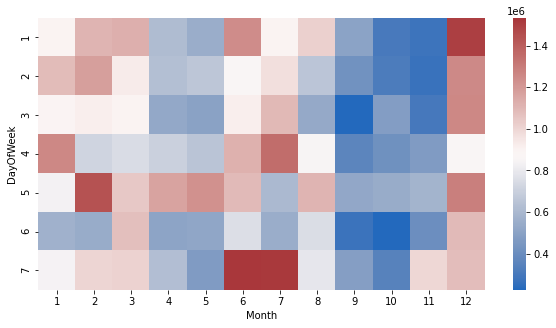

In [ ]:
DELAY_THRESHOLD = 30

heatDat = df[['Month', 'DayOfWeek', 'DepDelay']]
heatDat = heatDat[heatDat['DepDelay'] > DELAY_THRESHOLD]
heatDat = heatDat.groupby(['Month', 'DayOfWeek']).sum().unstack(level=0)

plt.figure(figsize=(10, 5))
sns.heatmap(heatDat, cmap='vlag', xticklabels=range(1, 13))
plt.xlabel('Month')
plt.show()

- **Observations:**

    - The total amount of departure delays are really high during February's Thursdays, June's and July's Saturdays, and remain comparatively high throughout the entire December, when people take more flights due to Chirtmas and New Year celebrations

    - The end, from Saturday to Sunday, and start, from Monday to Wednesday, of the first three months also have fairly high total departure delay times. This is the same across June and July.

    - Regardless of days of week, September, October, and November turn out to almost always have low departure delay sums.

## Analysis Tests

### t-test

- In this section, I will compute t-score and their corresponding p-value of each pair of features.

- Null hypothesis $H_0$: The difference between means of two features are 0.

- We first change categorical data, eg. string ones, to numerical data. For example, orgin 'IAD' to dest 'TPA' will be coded as 135 to 286.

- This is necessary to work with tests and models that only work with numbers.

In [4]:
catFeatures = ['UniqueCarrier', 'TailNum', 'Origin', 'Dest']

for f in catFeatures:
    df[f] = df[f].astype('category').cat.codes

df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,UniqueCarrier,FlightNum,TailNum,DepDelay,Origin,Dest,Distance,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,17,335,3765,8.0,135,286,810,8.0,0,0.0,0.0,0.0,0.0,0.0
1,2008,1,3,4,754.0,735,17,3231,4125,19.0,135,286,810,10.0,0,0.0,0.0,0.0,0.0,0.0
2,2008,1,3,4,628.0,620,17,448,1957,8.0,140,48,515,17.0,0,0.0,0.0,0.0,0.0,0.0
3,2008,1,3,4,926.0,930,17,1746,3055,-4.0,140,48,515,7.0,0,0.0,0.0,0.0,0.0,0.0
4,2008,1,3,4,1829.0,1755,17,3920,2138,34.0,140,48,515,10.0,0,2.0,0.0,0.0,0.0,32.0


- In this demo project, we agreed to work on the data of one year. Hence, we can obmit the column Year. In general work, this should not be done.

In [5]:
df.drop(columns=['Year'], inplace=True)

In [ ]:
T = pd.DataFrame(index=df.columns, columns=df.columns)

for f1 in df.columns:
    for f2 in df.columns:
        if f1 == f2:
            T[f1][f2] = None
        else: 
            t, p = stats.ttest_ind(df[f1], df[f2])
            T[f1][f2] = (t, p)

In [ ]:
pd.set_option('max_column', 100)
pd.set_option('max_row', 100)

print('t-score and p-value of each feature pair:')
print(T)

t-score and p-value of each feature pair:
                                        Month                  DayofMonth  \
Month                                    None    (2597.954842826596, 0.0)   
DayofMonth          (-2597.954842826596, 0.0)                        None   
DayOfWeek           (1640.0866444030037, 0.0)    (3432.441951017938, 0.0)   
DepTime             (-7279.506705725513, 0.0)   (-7227.195802791907, 0.0)   
CRSDepTime          (-7445.740833138658, 0.0)   (-7391.821151585713, 0.0)   
UniqueCarrier      (-1822.4115703381224, 0.0)    (1145.407697684248, 0.0)   
FlightNum          (-2956.2738322814357, 0.0)  (-2943.7215523999184, 0.0)   
TailNum             (-4565.203427394674, 0.0)   (-4549.494191933697, 0.0)   
DepDelay           (-264.79176812518216, 0.0)    (415.4105977748728, 0.0)   
Origin              (-4599.070609982437, 0.0)  (-4275.2194038149455, 0.0)   
Dest                (-4606.890877530713, 0.0)   (-4284.685290421757, 0.0)   
Distance            (-3362.5796771

In [ ]:
P_THRESHOLD = 0.001

count = 0
for c in T.columns:
    for i in T.index:
        val = T[c][i]
        if val is not None:
            t, p = T[c][i]
            if p > P_THRESHOLD:
                count += 1

print(f'Number of feature pairs having p-value of t-score > {P_THRESHOLD}: {count}')

Number of feature pairs having p-value of t-score > 0.001: 0


- **Comments:**
    
    - All t-scores have high absolute values, meaning each feature is significantly different than each of the others. We can confidently reject the Null hypothesis.
    
    - A negative t-score just means a reversed directional effect.

    - All p-values are close to 0 meaning the t-test results are reliable.

    - In conclusion, we can confirm that all of our features are pairwise independent within t-test criteria.

### Mann Whitney U-test

- We will compute U-score and their corresponding p-value of each pair of features.

- Null hypothesis $H_0$: The distributions of two features are identical such that there is a 50% probability that for two randomly selected samples, each from one feature, one sample will be greater than the other.

- We continue to use the dataset that all categorical values are already coded to numeric that we obtained before carrying out t-test.

In [ ]:
U = pd.DataFrame(index=df.columns, columns=df.columns)

for f1 in df.columns:
    for f2 in df.columns:
        if f1 == f2:
            U[f1][f2] = None
        else: 
            u, p = stats.mannwhitneyu(df[f1], df[f2])
            U[f1][f2] = (u, p)

In [ ]:
print(U)

                                     Month               DayofMonth  \
Month                                 None   (9132651399534.5, 0.0)   
DayofMonth          (9132651399534.5, 0.0)                     None   
DayOfWeek          (13744773678339.0, 0.0)   (5317515877365.5, 0.0)   
DepTime               (17736227282.5, 0.0)     (40647767010.0, 0.0)   
CRSDepTime             (2092715505.5, 0.0)      (7812484979.0, 0.0)   
UniqueCarrier      (12386690073944.0, 0.0)  (16483205648887.5, 0.0)   
FlightNum            (145641852477.5, 0.0)    (360649180888.5, 0.0)   
TailNum               (88966624407.0, 0.0)    (188494096787.0, 0.0)   
DepDelay           (13184854676862.0, 0.0)   (9617461388667.5, 0.0)   
Origin               (330420504623.5, 0.0)   (1960829192787.5, 0.0)   
Dest                 (330941484219.5, 0.0)   (1959527827116.0, 0.0)   
Distance                  (1574917.0, 0.0)        (61088517.0, 0.0)   
TaxiOut             (4945181485191.0, 0.0)  (23044021652742.5, 0.0)   
Divert

In [ ]:
criticalU = (len(df.index) ** 2) / 2
print(f'U critical value, (record counts ^ 2) / 2 = {criticalU} = {criticalU:.6e}') 
# as all features have the same record counts

P_THRESHOLD = 0.001

countp = 0
countu = 0
for c in U.columns:
    for i in U.index:
        val = U[c][i]
        if val is not None:
            u, p = U[c][i]
            if p > P_THRESHOLD:
                countp += 1
            if u >= criticalU:
                countu += 1

print(f'Number of feature pairs having U >= Critical value: {countu}')
print(f'Number of feature pairs having p-value of U > {P_THRESHOLD}: {countp}')

U critical value, (record counts ^ 2) / 2 = 23622377402162.0 = 2.362238e+13
Number of feature pairs having U >= Critical value: 0
Number of feature pairs having p-value of U > 0.001: 0


- **Comments:**

    - All U values are compararitively smaller than the critical value; hence we can confidently reject the Null hypothesis and confirm that every feature has a different distribution than each of the others.

    - All p-values are small and close to 0, which means the U-test results are extremely reliable.

## Prediction Models

### Categorical: Late or Not Late

- Models presented in this section will deal with a classification problem to predict whether the flight is late or not when on departure.

- *Again, a flight is late on departure if its DepDelay time exceeding 30 minutes. Exactly 30 minutes still count as on time (not late).*

- All models will be trained and tested on the same training and testing set for fair comparisons later.

#### Training and Testing data preparation



- First, a label for a flight departure delay will be calculated, as 1 (True) if DepDelay value > 30 (minutes), and 0 (False) otherwise.

In [6]:
cat_X = df[df.columns.drop('DepDelay')]
cat_y = [1 if d > 30 else 0 for d in df['DepDelay'].values]

- Using 30% of the records for testing, 70% for training.

In [7]:
TEST_SIZE = 0.3
RANDOM_STATE = 1108 # Just for reproducing the splitting in cases

cat_train_X, cat_test_X, cat_train_y, cat_test_y = train_test_split(cat_X, cat_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=cat_y)
# stratify: retain the same proportion of samples per class when splitting

In [8]:
print(f'Total number of records: {len(df.index)}')
print(f'Number of training samples: {len(cat_train_X)}')
print(f'Number of testing samples: {len(cat_test_X)}')

Total number of records: 6873482
Number of training samples: 4811437
Number of testing samples: 2062045


#### Naive Bayes

In [ ]:
model_NB = GaussianNB()
model_NB.fit(cat_train_X, cat_train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
cat_yhat_NB = model_NB.predict(cat_test_X)
acc_NB = accuracy_score(cat_test_y, cat_yhat_NB)

In [ ]:
print(f'Naive Bayes model\'s accuracy: {acc_NB} ~ {acc_NB * 100:.4f}%')

Naive Bayes model's accuracy: 0.9566798978683783 ~ 95.6680%


#### Logistic Regression

In [ ]:
model_LogR = LogisticRegression(solver='saga', max_iter=200)
model_LogR.fit(cat_train_X, cat_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

- **Notice:** 
    
    - It seems that we still did not run enough iterations for the coefficients to converge. However, let us see how the model currently performs.

    - *We are using SAGA solver, a modified version of Stochastic Average Gradient, which is suitable for large dataset.*

In [ ]:
cat_yhat_LogR = model_LogR.predict(cat_test_X)
acc_LogR = accuracy_score(cat_test_y, cat_yhat_LogR)

In [ ]:
print(f'Logistic Regression model\'s accuracy: {acc_LogR} ~ {acc_LogR * 100:.4f}%')

Logistic Regression model's accuracy: 0.9735975694031895 ~ 97.3598%


- The accuracy is not bad, with almost 2% higher than that of Naive Bayes.

#### Random Forest Classification

- We also have Random Forest (RF) Regression, but for demonstration, RF Classfication will be carried out.

In [ ]:
N_ESTIMATORS = 100
CRITERION = 'gini' # gini/entropy

model_RFC = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, n_jobs=-1)
# n_jobs = -1 means using all cores

model_RFC.fit(cat_train_X, cat_train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
cat_yhat_RFC = model_RFC.predict(cat_test_X)
acc_RFC = accuracy_score(cat_test_y, cat_yhat_RFC)

In [ ]:
print(f'Random Forest model\'s accuracy: {acc_RFC} ~ {acc_RFC * 100:.4f}%')

Random Forest model's accuracy: 0.986922690823915 ~ 98.6923%


#### Histogram-based Gradient Boosting Classification

- We also have Gradient Boosting Regression if we want to predict continuous departure delay time.

- Histogram-based version of Gradient Boosting is much faster for large dataset.

In [ ]:
N_ITERS = 100
LEARNING_RATE = 0.1

model_GBC = HistGradientBoostingClassifier(learning_rate=LEARNING_RATE, max_iter=N_ITERS)

model_GBC.fit(cat_train_X, cat_train_y)

HistGradientBoostingClassifier()

In [ ]:
cat_yhat_GBC = model_GBC.predict(cat_test_X)
acc_GBC = accuracy_score(cat_test_y, cat_yhat_GBC)

In [ ]:
print(f'Gradient Boosting model\'s accuracy: {acc_GBC} ~ {acc_GBC * 100:.4f}%')

Gradient Boosting model's accuracy: 0.9888450543028886 ~ 98.8845%


#### Neural Network - Multilayer Perceptron

In [28]:
DROPOUT_RATE = 0.1

model_NN = Sequential([
    Dense(64, input_dim=18, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(16, activation='relu'),
    Dropout(DROPOUT_RATE),
    Dense(1, activation='sigmoid')
])

print(model_NN.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                1216      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [23]:
cat_train_X_NN = cat_train_X.values.reshape(-1, 18)
cat_train_y_NN = np.array(cat_train_y).reshape(-1, 1)

print(cat_train_X_NN.shape)
print(cat_train_y_NN.shape)

(4811437, 18)
(4811437, 1)


- Using 30% of the training set as validation set. The training set is 70% of the total, so the validation set is 21% of the total and the new training set is 49%.

In [31]:
BATCH_SIZE = 1024
OPTIMIZER = 'adam'
VALIDATION_SPLIT = 0.3

NNcallback = ModelCheckpoint(filepath='./model_NN/model_NN', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

model_NN.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])
history = model_NN.fit(cat_train_X_NN, cat_train_y_NN, epochs=20, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[NNcallback])

Epoch 1/20
3290/3290 [==============================] - 13s 4ms/step - loss: 0.7144 - accuracy: 0.8781 - val_loss: 0.1338 - val_accuracy: 0.8815
Epoch 2/20
3290/3290 [==============================] - 12s 4ms/step - loss: 0.1215 - accuracy: 0.9587 - val_loss: 0.0786 - val_accuracy: 0.9727
Epoch 3/20
3290/3290 [==============================] - 14s 4ms/step - loss: 0.0779 - accuracy: 0.9721 - val_loss: 0.0513 - val_accuracy: 0.9794
Epoch 4/20
3290/3290 [==============================] - 14s 4ms/step - loss: 0.0584 - accuracy: 0.9777 - val_loss: 0.0439 - val_accuracy: 0.9818
Epoch 5/20
3290/3290 [==============================] - 12s 4ms/step - loss: 0.0514 - accuracy: 0.9800 - val_loss: 0.0504 - val_accuracy: 0.9784
Epoch 6/20
3290/3290 [==============================] - 11s 3ms/step - loss: 0.0483 - accuracy: 0.9813 - val_loss: 0.0500 - val_accuracy: 0.9826
Epoch 7/20
3290/3290 [==============================] - 13s 4ms/step - loss: 0.0457 - accuracy: 0.9822 - val_loss: 0.0439 - val_ac

In [35]:
# Using the weights that give the best validation accuracy
model_NN.load_weights('./model_NN/model_NN')

In [36]:
cat_test_X_NN = cat_test_X.values.reshape(-1, 18)
cat_test_y_NN = np.array(cat_test_y).reshape(-1, 1)

print(cat_test_X_NN.shape)
print(cat_test_y_NN.shape)

(2062045, 18)
(2062045, 1)


In [38]:
loss_NN, acc_NN = model_NN.evaluate(cat_test_X_NN, cat_test_y_NN, batch_size=BATCH_SIZE)

2014/2014 [==============================] - 4s 2ms/step - loss: 0.0181 - accuracy: 0.9927


In [40]:
print(f'Neural Network model\'s accuracy: {acc_NN} ~ {acc_NN * 100:.4f}%')

Neural Network model's accuracy: 0.9926984906196594 ~ 99.2698%


### Continuous: How much Late

- Models presented in this section will deal with a regression problem to predict how late on departure a flight could be.

- *We will not consider directly the 30 minutes threshold here.* Based on the predicted delay time value, futher classifications can be done easily.

- *Negative values are allowed for early departure meaning.*

- All models will be trained and tested on the same training and testing set for fair comparisons later.

#### Training and Testing data preparation

- Using 30% of the records for testing, 70% for training.

In [9]:
cont_X = df[df.columns.drop('DepDelay')]
cont_y = df['DepDelay'].values

RANDOM_STATE = 1108 # For preproducing the same splitting if needed, eg. when kernel crashes
TEST_SIZE = 0.3

cont_train_X, cont_test_X, cont_train_y, cont_test_y = train_test_split(cont_X, cont_y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [10]:
print(f'Total number of records: {len(df.index)}')
print(f'Number of training samples: {len(cont_train_X)}')
print(f'Number of testing samples: {len(cont_test_X)}')

Total number of records: 6873482
Number of training samples: 4811437
Number of testing samples: 2062045


#### Support Vector Machine (SVM) Regression (SVR)

- Originally, we have SVM Classification (SVC); however, in this section, we will demonstrate Support Vector Regression (SVR) instead.

In [11]:
# KERNEL = 'linear' # linear/poly/rbf/sigmoid/precomputed
# model_SVR = svm.SVR(kernel=KERNEL)
# 'linear' libsvm is not suitable for large dataset

model_SVR = svm.LinearSVR(fit_intercept=True)
model_SVR.fit(cont_train_X, cont_train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

- By default, SVR use RBF kernel, which is non-linear, giving time complexity of $O(n_{samples}^2 \times n_{features})$. With over 4 million records from our training set, this is too overwhelming for the current resource.

- Therefore, we will demonstrate SVR with a linear kernel.

- LinearSVR implements liblinear - $O(n)$, which is faster and more suitable for large dataset than SVR with kernel='linear' (libsvm) - $O(n^2)$

In [12]:
acc_SVR = model_SVR.score(cont_test_X, cont_test_y)

In [13]:
print(f'SVR model\'s accuracy: {acc_SVR} ~ {acc_SVR * 100:.4f}%')

SVR model's accuracy: 0.9136691839180849 ~ 91.3669%


#### Decision Tree Regression

- Similarly, we originally have Decision Tree for classification; again, we will now demonstrate Decision Tree for regression instead.

In [ ]:
CRITERION = 'mse' # mse/friedman_mse/mae/poisson

RANDOM_STATE = 1108

model_DTR = tree.DecisionTreeRegressor(criterion=CRITERION, random_state=RANDOM_STATE)
model_DTR.fit(cont_train_X, cont_train_y)

DecisionTreeRegressor(random_state=1108)

In [ ]:
acc_DTR = model_DTR.score(cont_test_X, cont_test_y)

In [ ]:
print(f'Decision Tree Regressor model\'s accuracy: {acc_DTR} ~ {acc_DTR * 100:.4f}%')

Decision Tree Regressor model's accuracy: 0.9644047877868939 ~ 96.4405%


#### Linear Regression - Ordinary Least Squares (OLS) 

In [ ]:
# fit_intercept will add a column of 1 (a virtual variable) for W0 (a bias/free coefficient)
# As Y ~ W0 * 1 + W1 * X1 + ... + Wn * Xn

model_OLS = LinearRegression(fit_intercept=True, n_jobs=-1)
model_OLS.fit(cont_train_X, cont_train_y)

LinearRegression(n_jobs=-1)

In [ ]:
acc_OLS = model_OLS.score(cont_test_X, cont_test_y)

In [ ]:
print(f'OLS Linear model\'s accuracy: {acc_OLS} ~ {acc_OLS * 100:.4f}%')

OLS Linear model's accuracy: 0.925745239604188 ~ 92.5745%


## Feature Selection Models

### Data preparation

- We will reuse the data for classfier models where the DepDelay is coded into categories as 0 or 1.

In [ ]:
fsDat = df[cat_X.columns.values]
fsDat.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,UniqueCarrier,FlightNum,TailNum,Origin,Dest,Distance,TaxiOut,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,17,335,3765,135,286,810,8.0,0,0.0,0.0,0.0,0.0,0.0
1,1,3,4,754.0,735,17,3231,4125,135,286,810,10.0,0,0.0,0.0,0.0,0.0,0.0
2,1,3,4,628.0,620,17,448,1957,140,48,515,17.0,0,0.0,0.0,0.0,0.0,0.0
3,1,3,4,926.0,930,17,1746,3055,140,48,515,7.0,0,0.0,0.0,0.0,0.0,0.0
4,1,3,4,1829.0,1755,17,3920,2138,140,48,515,10.0,0,2.0,0.0,0.0,0.0,32.0


### Principle Component Analysis (PCA)

In [ ]:
N_COMPONENTS = 'mle' # Using 'mle' for Minka's MLE to auto guess the suitable number of components
RANDOM_STATE = 1108

pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
pca.fit(fsDat)

PCA(n_components='mle', random_state=1108)

In [ ]:
print(f'Suggested number of components from PCA: {pca.n_components_}')

Suggested number of components from PCA: 17


- MLE is suggesting keeping 17/18 features, but we want to try even smaller subset of them.

In [ ]:
N_COMPONENTS = len(fsDat.columns) // 2 # Try to use half the amount of dimensions
RANDOM_STATE = 1108

pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
pca.fit(fsDat)

PCA(n_components=9, random_state=1108)

In [ ]:
print(f'The total explained variance ratio of all dimensions: {sum(pca.explained_variance_ratio_)}')

The total explained variance ratio of all dimensions: 0.9999144820325355


- So with these 9 pricipal axes we can still explain 99.99% of our original data, which is extremely good.

#### Applying PCA to Gradient Boosting Classfier

- We will try to apply PCA to get new data with reduced number of dimensions before doing classification with Histogram-based Gradient Boosting, and see whether this affects the performance or not.

In [ ]:
fsTrain = pca.transform(cat_train_X)
fsTest = pca.transform(cat_test_X)

In [ ]:
print(f'Transformed data shape: {fsTrain.shape}, {fsTest.shape}')

Transformed data shape: (4811437, 9), (2062045, 9)


In [ ]:
N_ITERS = 100
LEARNING_RATE = 0.1

model_GBC_PCA = HistGradientBoostingClassifier(learning_rate=LEARNING_RATE, max_iter=N_ITERS)
model_GBC_PCA.fit(fsTrain, cat_train_y)

HistGradientBoostingClassifier()

In [ ]:
acc_GBC_PCA = model_GBC_PCA.score(fsTest, cat_test_y)

In [ ]:
print(f'Gradient Boosting model with PCA scores {acc_GBC_PCA * 100:.4f}% accuracy')

Gradient Boosting model with PCA scores 99.2383% accuracy


- So compared to the original accuracy, 98.8845%, PCA helps Gradient Boosting model performs roughly 3.5% better.

### SelectKBest

In [ ]:
# Using ANOVA F-value for comparison by default

N_COMPONENTS = len(fsDat.columns) // 2

skb = SelectKBest(k=N_COMPONENTS)
skb.fit(fsDat, cat_y)

SelectKBest(k=9, score_func=<function f_classif at 0x7f37d3742830>)

In [ ]:
skbTrain = skb.transform(cat_train_X)
skbTest = skb.transform(cat_test_X)
print(f'Transformed data shape: {skbTrain.shape}, {skbTest.shape}')

Transformed data shape: (4811437, 9), (2062045, 9)


#### Applying SelectKBest to Gradient Boosting Classfier

In [ ]:
N_ITERS = 100
LEARNING_RATE = 0.1

model_GBC_SKB = HistGradientBoostingClassifier(learning_rate=LEARNING_RATE, max_iter=N_ITERS)
model_GBC_SKB.fit(skbTrain, cat_train_y)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [ ]:
acc_GBC_SKB = model_GBC_SKB.score(skbTest, cat_test_y)
print(f'Gradient Boosting model with SelectKBest scores {acc_GBC_SKB * 100:.4f}% accuracy')

Gradient Boosting model with SelectKBest scores 98.9258% accuracy


- Compared to the original accuracy, 98.8845%, and the PCA version's, 99.2383%, SelectKBest helps Gradient Boosting outperforms the original one by 0.04% but loses to PCA by 0.31%.

### Recursive Feature Elimination (RFE)

- We will use Stochastic Gradient Descent (SGD) Classifier, which utilizes a Support Vector Classifier (SVC) by default, as the estimator for RFE. This is for demonstration only.

- With limited resource, the algorithm will be run with step 9, meaning eliminating 9 features each time. For an ideal run and better performance, set step to 1.

In [ ]:
estimator = SGDClassifier()

N_COMPONENTS = len(fsDat.columns) // 2
STEP = 9 # Try smaller step if resource allows (ideal = 1)

rfe = RFE(estimator, n_features_to_select=N_COMPONENTS, step=STEP)
rfe.fit(fsDat, cat_y)

RFE(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                            early_stopping=False, epsilon=0.1, eta0=0.0,
                            fit_intercept=True, l1_ratio=0.15,
                            learning_rate='optimal', loss='hinge',
                            max_iter=1000, n_iter_no_change=5, n_jobs=None,
                            penalty='l2', power_t=0.5, random_state=None,
                            shuffle=True, tol=0.001, validation_fraction=0.1,
                            verbose=0, warm_start=False),
    n_features_to_select=9, step=9, verbose=0)

In [ ]:
rfeTrain = rfe.transform(cat_train_X)
rfeTest = rfe.transform(cat_test_X)
print(f'Transformed data shape: {rfeTrain.shape}, {rfeTest.shape}')

Transformed data shape: (4811437, 9), (2062045, 9)


#### Applying RFE to Gradient Boosting Classifier

In [ ]:
N_ITERS = 100
LEARNING_RATE = 0.1

model_GBC_RFE = HistGradientBoostingClassifier(learning_rate=LEARNING_RATE, max_iter=N_ITERS)
model_GBC_RFE.fit(rfeTrain, cat_train_y)

HistGradientBoostingClassifier(l2_regularization=0.0, learning_rate=0.1,
                               loss='auto', max_bins=255, max_depth=None,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                               random_state=None, scoring=None, tol=1e-07,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

In [ ]:
acc_GBC_RFE = model_GBC_RFE.score(rfeTest, cat_test_y)
print(f'Gradient Boosting model with RFE scores {acc_GBC_RFE * 100:.4f}% accuracy')

Gradient Boosting model with RFE scores 98.1148% accuracy


- Compared to the original accuracy, 98.8845%, the PCA version's, 99.2383%, and the SelectKBest version's, 98.9258%, RFE poorly loses to all of them. It scores even 0.77% lower than the original accuracy.

## Model Comparison and Analysis

### Comparing classification models for the categorical variable problem

In [ ]:
accs = pd.DataFrame(index=['NaiveBayes', 'LogisticRegression', 'RandomForest', 'GradientBoosting', 'MultilayerPerceptron'], columns=['Accuracy'], data=[[acc_NB], [acc_LogR], [acc_RFC], [acc_GBC], [acc_NN]])
accs.sort_values(['Accuracy'], axis=0, inplace=True, ascending=False)

- **Performance table for demonstrated models:**

In [ ]:
print(accs)

                      Accuracy
MultilayerPerceptron  0.992698
GradientBoosting      0.988845
RandomForest          0.986923
LogisticRegression    0.973598
NaiveBayes            0.956680


- **Fully connected Neural Network scores best.**
    - This is not surprise as it gives a non-linear classfication line that supremely fits and separates our data.
    - However, with such a large dataset, overfiting can easily occurs, although we have already put in some dropout layers.

- **Histogram-based Gradient Boosting scores second.**
    - As an ensemble of sub linear models, it should outperform single linear ones such as logistic regression.

- **Random Forest scores third.**
    - With the same nature of an ensemble method like Gradient Boosting, it scores quite well.

- **Logistic Regression scores fourth.**
    - A single linear classifier as logistic regression cannot be more accurate than a combination of many linear solutions like Gradient Boosting or Random Forest.

- **Naive Bayes scores worst.**
    - As a simple statistic model, it is not supposed to compete with more complicated ones as the others.

### Comparing regression models for the continuous variable problem

In [ ]:
accsReg = pd.DataFrame(index=['SupportVectorRegression', 'DecisionTreeRegression', 'OLSLinearRegression'], columns=['Accuracy'], data=[[acc_SVR], [acc_DTR], [acc_OLS]])
accsReg.sort_values(['Accuracy'], axis=0, inplace=True, ascending=False)

- **Performance table for demonstrated models:**

In [ ]:
print(accsReg)

                         Accuracy
DecisionTreeRegression   0.964405
OLSLinearRegression      0.925745
SupportVectorRegression  0.913669


- **Decision Tree Regression scores best.**
    - Being a non-linear model, decision tree should outpeform the other linear ones. Working like neural networks, which doing sub classification (passing through a layer) out of previous classification (from the previous layer), decision tree splits the data many times into smaller and smaller subsets.
    - For regression, it does splitting in a way that minimizes the sum of squared residuals.

- **OLS Linear Regression scores second.**
    - There is no doubt, as explained above, it loses to Decision Tree.
    - For a large number of features, there will be a high probability that multicolinearity exists, which makes our model unreliable.
    - Multicolinearity tests such as Variance Inflation Factor (VIF) should be carried out to investigate the dependence between any pair of features.

- **Linear Support Vector Regression scores worst.**
    - If we have more resource to use a non-linear kernel such as RBF, it may score higher.

### Comparing feature selection techniques

- As presented in details while testing each technique with Histogram Gradient Boosting, here is a brief summary:

    - **PCA is the best choice** when scores higher than the original Boosting and both SelectKBest and RFE.

    - **SelectKBest is still a good choice** when at least its accuracy exceeds the orginal one.

    - **RFE is not recommended** since it scores even lower than the original accuracy.
        - Maybe with better resource, we can try more complicated estimator for it, other than SGD Classfier.

## Model Tuning

### Theoretical approaches

- In this section, ways to improve each model's performance will be discussed.

- **For Naive Bayes:**
    - Using log probabilities.
    - Using other distributions.
    - Use probabilities for feature selection.
    - Remove redundant features by applying feature selection.
    - Segment the data.

- **For linear models such as OLS Linear Regression and Logistic Regression:**
    - Checking and removing multicolinearity.
    - Normalizing features, eg. by z-scores.
    - Checking for class imbalance (if for classification problems).
    
- **For ensemble models such as Boosting and Random Forest:**
    - Tuning the hyperparameters such as number of weak models (components), number of iterations, ...

- **For Decision Tree:**
    - We can try apply Boosting where each weak model is a Decistion Tree classifier/regressor.

- **For Neural Network:**
    - Experimenting different network structures.
    - Using k-fold for cross-validation in training.
    - Tuning hyperparameters such as batch sizes, number of epochs, ...
    - Using different optimizers and activations.

### Tuning the Neural Network model

- For demonstration, I can only experiment with the Neural Network model for the classification problem.

In [17]:
def buildNN(hp):

    MIN_DENSE_N = 16
    MAX_DENSE_N = 512
    STEP_N = 16
    DEFAULT_N = 128

    ACTIVATIONS = ['relu', 'tanh', 'sigmoid']
    DEFAULT_F = 'relu'

    MIN_DROP = 0.0
    MAX_DROP = 0.5
    STEP_DROP = 0.1
    DEFAULT_DROP = 0.1
    
    model = Sequential([ 
        Dense(units=hp.Int('units1', min_value=MIN_DENSE_N, max_value=MAX_DENSE_N, step=STEP_N, default=DEFAULT_N),
              activation=hp.Choice('dense_activation1', values=ACTIVATIONS, default=DEFAULT_F)),
        Dropout(rate=hp.Float('dropout1', min_value=MIN_DROP, max_value=MAX_DROP, step=STEP_DROP, default=DEFAULT_DROP)),
        Dense(units=hp.Int('units2', min_value=MIN_DENSE_N, max_value=MAX_DENSE_N, step=STEP_N, default=DEFAULT_N),
              activation=hp.Choice('dense_activation2', values=ACTIVATIONS, default=DEFAULT_F)),
        Dropout(rate=hp.Float('dropout1', min_value=MIN_DROP, max_value=MAX_DROP, step=STEP_DROP, default=DEFAULT_DROP)),
        Dense(units=hp.Int('units3', min_value=MIN_DENSE_N, max_value=MAX_DENSE_N, step=STEP_N, default=DEFAULT_N),
              activation=hp.Choice('dense_activation3', values=ACTIVATIONS, default=DEFAULT_F)),
        Dropout(rate=hp.Float('dropout1', min_value=MIN_DROP, max_value=MAX_DROP, step=STEP_DROP, default=DEFAULT_DROP)),
        Dense(units=1, activation='sigmoid')       
    ])

    model.compile(loss='binary_crossentropy', metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG', default=0.001)))
    
    return model

tuner = RandomSearch(buildNN, objective='val_accuracy', max_trials=5, directory='./', project_name='NN-tuning', executions_per_trial=1)
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project ./NN-tuning/oracle.json
Search space summary
Default search space size: 8
units1 (Int)
{'default': 128, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
dense_activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
units2 (Int)
{'default': 128, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
dense_activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
units3 (Int)
{'default': 128, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 16, 'sampling': None}
dense_activation3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'condi

In [18]:
tuner.search(cat_train_X_NN, cat_train_y_NN, epochs=20, validation_split=0.3, batch_size=1024)

Trial 5 Complete [00h 08m 23s]
val_accuracy: 0.977241039276123

Best val_accuracy So Far: 0.9821681976318359
Total elapsed time: 00h 39m 50s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary()

Results summary
Results in ./NN-tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units1: 480
dense_activation1: tanh
dropout1: 0.30000000000000004
units2: 512
dense_activation2: sigmoid
units3: 192
dense_activation3: sigmoid
learning_rate: 0.000283322409508102
Score: 0.9821681976318359
Trial summary
Hyperparameters:
units1: 432
dense_activation1: tanh
dropout1: 0.30000000000000004
units2: 240
dense_activation2: tanh
units3: 32
dense_activation3: tanh
learning_rate: 0.00021148822061093226
Score: 0.9811373353004456
Trial summary
Hyperparameters:
units1: 240
dense_activation1: sigmoid
dropout1: 0.4
units2: 224
dense_activation2: relu
units3: 320
dense_activation3: tanh
learning_rate: 0.0017203964942403656
Score: 0.978061318397522
Trial summary
Hyperparameters:
units1: 464
dense_activation1: tanh
dropout1: 0.1
units2: 240
dense_activation2: relu
units3: 112
dense_activation3: sigmoid
learning_rate: 0.0009403511195530857
Score: 0.9

In [ ]:
%%capture
bestNN = tuner.get_best_models()[0]

In [28]:
loss, acc = bestNN.evaluate(cat_test_X_NN, cat_test_y_NN, batch_size=1024)

2014/2014 [==============================] - 6s 3ms/step - loss: 0.0411 - accuracy: 0.9820


- The accuracy from the best randomly built model is actually worse than our manually built one.

- However, this is only for demonstrating the way to tune a Neural Network. With more trials, executions, and configurations, a better model is sure to be found.

## Conclusion

- **About the data:**
    - The data are not well described from the original authors. Some of the features are vague in meanings. Contraints and relationships among features are manually inferred most of the times.
    - Buffering techniques are necessary to work with such a large dataset.
    - z-scores can be used to normalized values for better performance of tests and models.
    - There is an interesting fact that the number of flights departing early is more than those late, and most late ones happen in December.

- **About prediction models:**
    - Non-linear solutions such as Neural Networks, Decision Trees, non-linear SVM, ... are highly recommended.
    - Ensemble methods such as Boosting or Random Forest are also suitable.
    - Linear models and Naive Bayes do not perform well compared to the others, but they can compensate for fast computational speed.

- **About feature selection models:**
    - PCA is highly recommended for both speed and effectiveness.
    - SelectKBest can be another fairly good choice.
    - RFE is not good enough to be proposed, and the running time is rather high.

- **Future works:**
    - Trying other classification and regression models.
    - Carrying out model tuning approaches.
    - Continuing to perform tuning for Neural Network in a larger space with more trials.


## References

- Data Expo 2009 - Airline on-time performance, [url](https://community.amstat.org/jointscsg-section/dataexpo/dataexpo2009).

- Matplotlib Documentation, [url](https://matplotlib.org/stable/contents.html).

- Pandas Documentation, [url](https://pandas.pydata.org/docs/).

- t-Test: Definition and Examples, [url](https://www.statisticshowto.com/probability-and-statistics/t-test/).

- Seaborn Documentation, [url](https://seaborn.pydata.org/).

- Mann Whitney U-Test: Definition & How to, [url](https://www.statisticshowto.com/mann-whitney-u-test/).

- Interpreting results: Mann-Whitney test, [url](https://www.graphpad.com/guides/prism/latest/statistics/how_the_mann-whitney_test_works.htm).

- Scikit-Learn User Guide, [url](https://scikit-learn.org/stable/user_guide.html).

- Naive Bayes, [url](https://scikit-learn.org/stable/modules/naive_bayes.html).

- Linear Model: Logistic Regression, [url](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

- Logistic Regression convergence problems and solver choices, [url](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter).

- Forest of randomized trees, [url](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees).

- Histogram-based Gradient Boosting, [url](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

- Support Vector Regression, [url](https://scikit-learn.org/stable/modules/svm.html#regression).

- Decision Tree Regression, [url](https://scikit-learn.org/stable/modules/tree.html#regression).

- Keras Documentation, [url](https://keras.io/).

- Decomposing signals in components (matrix factorization problems), [url](https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca).

- PCA using Python (scikit-learn), [url](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60).

- Univariate feature selection, [url](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

- Linear regression vs Decision trees, [url](https://mlcorner.com/linear-regression-vs-decision-trees/).

*All links were last accessed on **June 01, 2021**.*